In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, tree
import seaborn as sns

<h1>Importación de datos</h1>

In [2]:
df = pd.read_csv("emnist_letters_tp.csv", header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Q,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1>Analisis exploratorio de datos</h1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62400 entries, 0 to 62399
Columns: 785 entries, 0 to 784
dtypes: int64(784), object(1)
memory usage: 373.7+ MB


In [5]:
df[0].nunique()

26

In [6]:
df[0].value_counts()

0
F    2400
Q    2400
I    2400
B    2400
X    2400
R    2400
A    2400
G    2400
V    2400
U    2400
Y    2400
M    2400
N    2400
S    2400
Z    2400
P    2400
T    2400
J    2400
E    2400
H    2400
C    2400
O    2400
D    2400
K    2400
W    2400
L    2400
Name: count, dtype: int64

**Cantidad de datos** Hay 62400 filas, cada una con 785 columnas.<br>
**Atributos** Hay 785 atributos, 784 numericos y el primero es un caracter, el indicador de la letra (variable de interes).<br>
**Clase de interes** Hay  26 valores distintos para la clase de interes, todos presentes en igual proporcion.

<h3>Veamos algunos ejemplos de letras</h3>

In [7]:
def flip_rotate(image):
    """
    Función que recibe un array de numpy representando una
    imagen de 28x28. Espeja el array y lo rota en 90°.
    """
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [8]:
Es = df[df[0] == "E"]
Ls = df[df[0] == "L"]
Ms = df[df[0] == "M"]

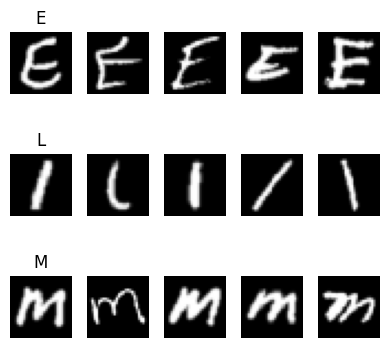

In [9]:
# Definir los dataframes en un diccionario para facilitar el bucle
letras = {'E': Es, 'L': Ls, 'M': Ms}

fig, axs = plt.subplots(3, 5, figsize=(4, 4))  # 3 filas para las letras, 5 columnas para ejemplos de cada letra

for i, (letras, data) in enumerate(letras.items()):
    # Obtener las primeras 5 imágenes del dataframe actual
    for j in range(5):
        row = data.iloc[j].drop(0)
        image_array = np.array(row).astype(np.float32)
        image = flip_rotate(image_array)
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(letras)

plt.tight_layout()
plt.show()

**Veamos las Ces**

<Figure size 640x480 with 0 Axes>

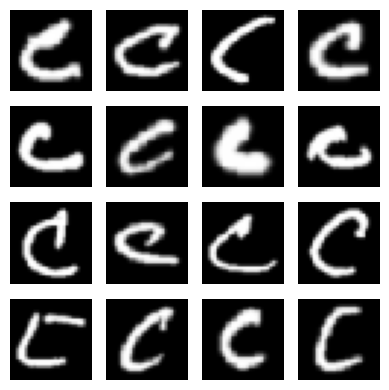

In [10]:
Cs = df[df[0] == "C"]

plt.clf()
fig, axs = plt.subplots(4,4, figsize=(4,4))

for i in range(4):
    for j in range(4):
        random = np.random.randint(0,2399) #elejimos un C al azar
        row = Cs.iloc[random].drop(0)
        image_array = np.array(row).astype(np.float32)
        image = flip_rotate(image_array)
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
Cs.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
7,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>Ejercicio 1</h3>
<h3>(a)</h3> Los atributos de los pixeles son la unica informacion que tenemos para predecir la letra correspondiente, por lo que son estos atributos (o columnas) fundamentales para lograr nuestra tarea. Sin embargo se puede notar que los valores correspondientes a las esquinas y bordes de la imagen son en su mayoria igual a cero. Quizas podriamos reducir la cantidad de piexeles por imagen y prescindir de esos datos.<br>
<h3>(b, c)</h3> Las letras no son parecidas, incluso varian mucho las imagenes de una misma letra. Sin embargo cabe notar que si se comparan de a tres (como con la E, la M y la L), se podría decir que hay un par con mas similitudes entre sí. Para el ejemplo arriba visto podemos observar mayores similitudes entre la M y la E, pues ambas presentan un patron de tres rayas, la E hacia la derecha y la M los presenta hacia abajo.<br>
<h3>(d)</h3> En este caso la exploración de datos se debe tomar por otro enfoque, no  se tratará de graficos de caja o de histogramas, ya que no servirian ningún proposito, lo importante en una base de datos de imagenes es poder verlas, ver patrones en ellas, identificar la cantidad de colores tal vez, el tamaño de cada imagen; y por sobre todas las cosas, ver que valores puede tomar cada imagen, para responder la cantidad de posibles valores distintos, y que porcentaje representa cada uno de estos en el conjunto de datos.

<hr>

<h3>Ejercicio 2</h3>

<h3>(a) y (b)</h3>

In [12]:
LAs = df[df[0].isin(["A","L"])] # item a

# (item b) por analisis anteriores sabemos que estos datos estan
# balanceados, ambas letras estan en 2400 filas

<h3>(c)</h3>

In [13]:
# separamos las labels
X = LAs.drop(0, axis=1)
y = LAs[0]

In [14]:
# separamos los datos en conjuntos train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

<h3>(d)</h3>

In [47]:
resultados3=[]

np.random.seed(42)
for i in range(15):   # pruebo con 15 combinaciones distintas
    combinacion = np.random.randint(1, 785, size=3)    # tomo de forma random 3 de las columnas 
    X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas random
    X_test_subset = X_test[combinacion]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_subset,y_train) 
    y_pred = knn.predict(X_test_subset)
    resultados3.append((combinacion,metrics.accuracy_score(y_test, y_pred)))

resultados3 = sorted(resultados3, key=lambda x: x[1], reverse=True)

print(resultados3)

[(array([344, 492, 414]), 0.9013888888888889), (array([467, 215, 331]), 0.8881944444444444), (array([386, 192, 277]), 0.8277777777777777), (array([687, 563, 567]), 0.7909722222222222), (array([161, 460, 314]), 0.7798611111111111), (array([103, 436, 271]), 0.7701388888888889), (array([100, 664, 131]), 0.7263888888888889), (array([700, 783, 190]), 0.6972222222222222), (array([511, 682, 476]), 0.6847222222222222), (array([662, 309, 770]), 0.6736111111111112), (array([459,  88, 373]), 0.625), (array([ 22, 253, 748]), 0.4951388888888889), (array([ 21, 615, 122]), 0.4930555555555556), (array([561, 475,  59]), 0.4895833333333333), (array([107,  72, 701]), 0.4701388888888889)]


344, 492, 414

Notamos que las columnas del medio nos dan un buen resultado, como es de esperarse.<br>
Probemos eligiendolas manualmente.

In [16]:
combinacion = [391,392,393]    # tomo las 3 columnas del medio
X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas seleccionadas
X_test_subset = X_test[combinacion]
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_subset,y_train) 
y_pred = knn.predict(X_test_subset)

In [17]:
print(metrics.accuracy_score(y_test, y_pred))

0.5305555555555556


Interesante, me dio muy mal la métrica, lo puedo interpretar como que las 3 columnas son muy redundantes en informacion, por lo reduzco la cantidad de datos significativos con los que el modelo puede predecir.

Veamos en un gráfico la idea.

<Figure size 640x480 with 0 Axes>

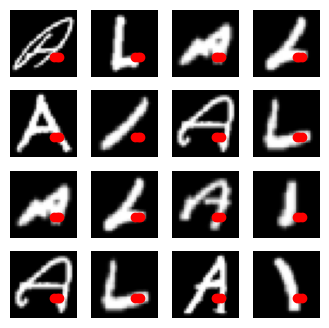

In [18]:
plt.clf()

np.random.seed(42)
random = np.random.randint(0,2399, size=16)
fig, axs = plt.subplots(4,4,figsize=(4,4))

for j in range(4):
    for i, letra in enumerate(["A","L","A","L"]):
        row = df[df[0] == letra].iloc[random[i + j + 2]].drop(0)
        image_array = np.array(row).astype(np.float32)
        image = flip_rotate(image_array)
        axs[j,i].imshow(image, cmap='gray')
        axs[j,i].scatter([18,19,20], [19,19,19],color='red') # señalamos 3 atributos cercanos
        axs[j,i].axis('off')

Se puede ver que 3 puntos cercanos no nos dan tanta informacion, ambas letras presentan ejemplos de puntos similares, donde hay casos que son todos blancos, o todos negros, o donde hay ambos colores; pero la proporcion de estos casos no varía mucho entre estos caracteres, por lo que dificulta la obtencion de un buen resultado usando el algoritmo de KNN.

**Veamos ahora que pasa con otra cantidad de atributos**

In [50]:
# probamos con 9 atributos

resultados9=[]
np.random.seed(42)
for i in range(15):   # pruebo con 15 combinaciones distintas
    combinacion = np.random.randint(1, 785, size=9)    # tomo de forma random 9 de las columnas 
    X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas random
    X_test_subset = X_test[combinacion]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_subset,y_train) 
    y_pred = knn.predict(X_test_subset)
    resultados9.append((combinacion,metrics.accuracy_score(y_test, y_pred)))

resultados9 = sorted(resultados9, key=lambda x: x[1], reverse=True)

print(resultados9)

[(array([764, 188, 380, 493,  41, 157,  15,  65, 521]), 0.9375), (array([662, 309, 770, 344, 492, 414, 386, 192, 277]), 0.9298611111111111), (array([135, 201, 780,  33,  48, 503, 407, 574, 728]), 0.9284722222222223), (array([467, 215, 331, 459,  88, 373, 100, 664, 131]), 0.9083333333333333), (array([244, 505, 131, 485, 647,  21, 167, 274, 388]), 0.8986111111111111), (array([601, 316,  14, 242, 777, 346, 565, 340,  92]), 0.8916666666666667), (array([730, 556, 162, 202, 270, 271, 456, 462, 727]), 0.8659722222222223), (array([511, 682, 476, 700, 783, 190, 687, 563, 567]), 0.8138888888888889), (array([103, 436, 271, 107,  72, 701,  21, 615, 122]), 0.8125), (array([344, 129, 648, 472,  63, 139, 499, 593, 392]), 0.7979166666666667), (array([388,   2, 390, 566, 106, 772, 477, 703, 402]), 0.7965277777777777), (array([252, 702, 296, 725, 720, 749, 338,  53, 217]), 0.7895833333333333), (array([675, 419, 289, 379, 773, 490, 231,  41,  28]), 0.7888888888888889), (array([161, 460, 314,  22, 253, 74

764, 188, 380, 493,  41, 157,  15,  65, 521

Hubo una mejora, de un 1%. Veamos que pasa si aumentamos la cantidad de atributos. Probemos con 21.

In [56]:
resultados12=[]
np.random.seed(42)
for i in range(15):   # pruebo con 15 combinaciones distintas
    combinacion = np.random.randint(1, 785, size=12)    # tomo de forma random 21 de las columnas 
    X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas random
    X_test_subset = X_test[combinacion]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_subset,y_train) 
    y_pred = knn.predict(X_test_subset)
    resultados12.append((combinacion,metrics.accuracy_score(y_test, y_pred)))

resultados12 = sorted(resultados12, key=lambda x: x[1], reverse=True)

print(resultados12[:5]) # imprimo solo los primeros 5, sino es muy largo

[(array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.9708333333333333), (array([ 36, 525, 160, 699, 243,  86, 578, 682, 557, 574, 646,  28]), 0.9506944444444444), (array([  5, 218, 503, 767, 398, 393, 207,  15, 554, 461, 691, 575]), 0.9416666666666667), (array([338,  53, 217, 764, 188, 380, 493,  41, 157,  15,  65, 521]), 0.9340277777777778), (array([103, 436, 271, 107,  72, 701,  21, 615, 122, 467, 215, 331]), 0.9256944444444445)]


In [57]:
# veamos un poco de informacion sobre los resultados obtenidos
print(f"""
    Con 3 atributos\n
         Exactitud máxima: {resultados3[0][1]:.3}.\n
         Exactitud media: {np.mean([exactitud[1] for exactitud in resultados3]):.3}.\n\n
    Con 9 atributos\n
         Exactitud máxima: {resultados9[0][1]:.3}.\n
         Exactitud media: {np.mean([exactitud[1] for exactitud in resultados9]):.3}.\n\n
    Con 12 atributos\n
         Exactitud máxima: {resultados21[0][1]:.3}.\n
         Exactitud media: {np.mean([exactitud[1] for exactitud in resultados12]):.3}.
""")


    Con 3 atributos

         Exactitud máxima: 0.901.

         Exactitud media: 0.688.


    Con 9 atributos

         Exactitud máxima: 0.938.

         Exactitud media: 0.842.


    Con 12 atributos

         Exactitud máxima: 0.971.

         Exactitud media: 0.888.



Observamos que la mejor marca no aumenta significativamente, sin embargo, en promedio los resultados para 15 experimentos son mucho mejores.

Tratemos de hacer un gráfico para enclarecer esta idea.

<h3>(e)</h3>

La idea ahora es comparar los modelos de KNN, perov variando tambien los numeros de vecinos

Nos va a facilitar la tarea modularizar el codigo en funciones que tomen lo que ya hemos hecho hasta ahora. Asi que primero hacemos eso para que luego sea mas sencillo entrenar modelos con diferentes parametros.

Elegimos usar 9 atributos, ya que la mayor exactitud no muestra diferencias en comparacion con elegir 21. De esta manera ahorramos tiempo, espacio y energia sin comprometer los resultados.

In [59]:
def kneigh(k):
    """
    Dado un k, entrena 15 modelos de kNN
    usando en cada iteración 12 atributos distintos.
    """
    resultados=[]
    np.random.seed(42)
    for i in range(15):   # pruebo con 15 combinaciones distintas
        combinacion = np.random.randint(1, 785, size=12)    # tomo de forma random 12 de las columnas 
        X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas random
        X_test_subset = X_test[combinacion]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_subset,y_train) 
        y_pred = knn.predict(X_test_subset)
        resultados.append((combinacion,metrics.accuracy_score(y_test, y_pred)))

    # ordenamos los resultados obtenidos segun la exactitud
    # para así poder acceder a los atributos con mejor resultado
    # con tan solo elegir el primer elemento de la lista.
    resultados = sorted(resultados, key=lambda x: x[1], reverse=True)
    return resultados[0] 


Probamos distintos valores de k.

In [60]:
ks = [3,6,9,12,15,20,25,32]

resultados_ks = {} # guardamos los datos en un dicc.

for k in ks:
    resultado = kneigh(k)
    resultados_ks[k] = resultado

In [61]:
print(resultados_ks)

{3: (array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.9708333333333333), 6: (array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.9722222222222222), 9: (array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.9729166666666667), 12: (array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.9729166666666667), 15: (array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.9715277777777778), 20: (array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.96875), 25: (array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.9652777777777778), 32: (array([407, 574, 728,  99, 684, 726, 547, 739, 613, 462, 643, 769]), 0.9645833333333333)}


Observamos que el mejor resultado se obtiene con 9 0 12, y que ademas no varía mucho la exactitud al cambiar el k, las exactitudes tienen un rango entre 95 y 97.3

Como la mejor exactitud lo dio el menor k de todos, probamos con k = 1 y k = 2, tal vez veamos alguna mejora.

In [25]:
print(kneigh(1)) # k = 1

(array([521,  99,  20, 753, 573, 490, 419, 690,  62]), 0.9527777777777777)


In [26]:
print(kneigh(2)) # k = 2

(array([195, 738, 332, 170, 521, 463,  40, 537, 261]), 0.9284722222222223)


Ambos dieron mas bajo que k = 3. Por lo que nos terminamos por decidir que k = 3 es la mejor opción.

**Concluimos por lo tanto que:**

In [63]:
print(f"""
    El mejor modelo de kNN (en exactitud):\n
         - Usa k = 9
         - Tiene en cuenta 12 atributos: {resultados_ks[9][0]}
         - Tiene exactitud (en el conjunto de test): {resultados_ks[9][1]:.3} 
""")


    El mejor modelo de kNN (en exactitud):

         - Usa k = 9
         - Tiene en cuenta 12 atributos: [407 574 728  99 684 726 547 739 613 462 643 769]
         - Tiene exactitud (en el conjunto de test): 0.973 



<hr>

<h3>Ejercicio 3</h3>

<h3>(a)</h3>

In [28]:
# separamos las vocales
df_vocales = df[df[0].isin(["A","E","I","O","U"])]

# separamos atributos de etiquetas
X_vocales = df_vocales.drop(0,axis="columns")
y_vocales = df_vocales[0]

# separamos los datos en train y en test
X_voc_train, X_voc_test, y_voc_train, y_voc_test = train_test_split(X_vocales, y_vocales, random_state=42, test_size=0.3)

<h3>(b)</h3>

In [29]:
# definimos una funcion para entrenar un modelo de arbol de decision
def accuracy_arbol(X, Y, testX, testY, hmax, criterio="gini"):
    arbol = tree.DecisionTreeClassifier(max_depth=hmax, criterion=criterio)
    arbol.fit(X, Y)

    pred = arbol.predict(testX)
    accuracy = np.mean([pred == testY])
    return accuracy

In [30]:
# probamos distintas profundidades
for h in range(1,12,2):
    acc_arbol = accuracy_arbol(X=X_voc_train,Y=y_voc_train,testX=X_voc_train,testY=y_voc_train,hmax=h)
    print(f'Para {h} de profundid, la exactitud fue de {acc_arbol:.2}')

Para 1 de profundid, la exactitud fue de 0.38
Para 3 de profundid, la exactitud fue de 0.7
Para 5 de profundid, la exactitud fue de 0.88
Para 7 de profundid, la exactitud fue de 0.94
Para 9 de profundid, la exactitud fue de 0.98
Para 11 de profundid, la exactitud fue de 0.99


Vemos que a partir de 11 la exactitud deja de mejorar, no se puede mejorar mas, estamos arriesgando a un problema de overfitting.

<h3>(c)</h3>

**Ahora hacemos validacion cruzada con k-folding**<br>
De esta manera tratamos de encontrar el mejor modelo.

Encontramos conveniente usar un DataFrame para registar los resultados de los experimentos.

In [79]:
# Creamos un DataFrame para registrar altura, criterio,y promedio de exactitud de cada arbol.
data = {"hmax":[],"criterio":[],"promedio_exactitud":[]}
registro = pd.DataFrame(data=data)

Ahora creamos una funcion para evaluar los arboles según su altura.

In [80]:
def matriz_kfold(criterio):
    """
    Devuelve el promedio de la exactitud  a travez de k-folds
    para cada altura de arbol de clasificacion.
    """
    alturas = [1,2,3,5,10,15]
    nsplits = 5
    kf = KFold(n_splits=nsplits, shuffle=True, random_state=42)

    resultados = np.zeros((nsplits, len(alturas)))

    for i, (train_index, test_index) in enumerate(kf.split(X_voc_train)):

        kf_X_train, kf_X_test = X_voc_train.iloc[train_index], X_voc_train.iloc[test_index]
        kf_y_train, kf_y_test = y_voc_train.iloc[train_index], y_voc_train.iloc[test_index]
        
        for j, hmax in enumerate(alturas):
            score = accuracy_arbol(hmax=hmax,X=kf_X_train,Y=kf_y_train,testX=kf_X_test,testY=kf_y_test,criterio=criterio)
            resultados[i, j] = score

    # para saber a que altura corresponde el puntaje lo devolvemos en tuplas
    scores_promedio = zip(alturas,resultados.mean(axis = 0))
    
    return scores_promedio


Nos queda correr el experimento una vez por cada **criterio**, registrando todo en cada iteracion.

In [81]:
criterios = ["gini", "entropy", "log_loss"] # lista para iterar y realizar los experimentos.

for criterio in criterios:
    scores = matriz_kfold(criterio=criterio)

    # agregamos los resultados al dataframe
    for h, score in scores:
        # agrego los resultados en una nueva fila
        registro.loc[len(registro.index)] = [h, criterio, score]

# lo ordenamos por exactitud
registro.sort_values(by="promedio_exactitud", ascending=False, inplace=True, ignore_index = True)

In [82]:
registro.head()

,hmax,criterio,promedio_exactitud
0,10,entropy,0.919524
1,15,entropy,0.918929
2,10,log_loss,0.918095
3,10,gini,0.916905
4,15,log_loss,0.916667


Vemos entonces que en el experimento de k-fold el mejor resultado lo obtenemos con arboles:
 - De profundidad maxima 10 (empata con 15)
 - Con criterio de 'entropy'
 - Obtiene un 92% de exactitud.

<h3>(d)</h3>

In [67]:
# entrenamos el modelo elegido en el item (c), esta vez con todo el df de entrenamiento
resultado_final = accuracy_arbol(X=X_voc_train
                                ,Y=y_voc_train
                                ,testX=X_voc_test
                                ,testY=y_voc_test
                                ,hmax=10
                                ,criterio="entropy")

print(f"La exactitud (sobre el conjunto de test) del modelo seleccionado es: {resultado_final:.2}")

La exactitud (sobre el conjunto de test) del modelo seleccionado es: 0.92


**Obtenemos una exactitud del 92%** como se esperaba por los resultados del k-fold.

Ahora analicemos los errores que comete el modelo mediante una matriz de confusion.

In [68]:
def matriz_confusion(pred, actual):
    señalador = {"A":0,"E":1,"I":2,"O":3,"U":4}
    matriz = np.zeros((5,5))

    for i in range(len(pred)):
        matriz[señalador[pred[i]], señalador[actual[i]]] += 1

    return matriz


In [39]:
arbol_elegido = tree.DecisionTreeClassifier(max_depth=10,criterion="entropy")
arbol_elegido.fit(X_voc_train, y_voc_train)
pred = arbol_elegido.predict(X_voc_test)
matrix = matriz_confusion(pred, list(y_voc_test)) # lo paso como lista para sacar los indices del split

In [69]:
matrix

array([[630.,  29.,   7.,  17.,  24.],
       [ 27., 636.,  16.,  13.,   5.],
       [ 10.,  13., 711.,   0.,  12.],
       [ 16.,   8.,   0., 670.,  17.],
       [ 31.,  11.,   5.,  18., 674.]])

Text(50.722222222222214, 0.5, 'Valores predichos')

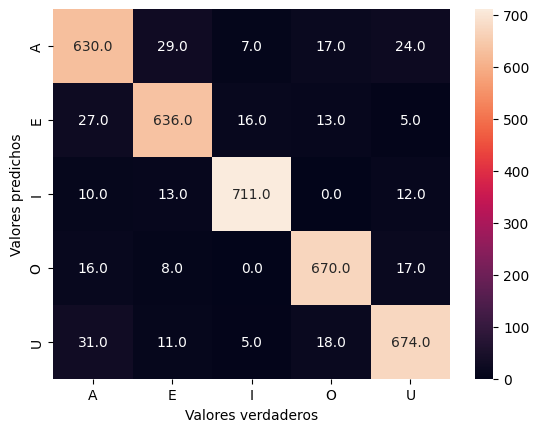

In [70]:
sns.heatmap(matrix, annot=True, fmt=".1f", xticklabels=["A","E","I","O","U"],yticklabels=["A","E","I","O","U"])
plt.xlabel("Valores verdaderos")
plt.ylabel("Valores predichos")